In [27]:
# Import Libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt

# Tampilkan semua kolom
pd.set_option('display.max_columns', None)

In [ ]:
# Load CSV
df = pd.read_csv("idx_shariah_weekly.csv")

# Tampilkan dulu 5 baris awal
print(df.head())

         Date   Price    Open    High     Low    Vol. Change %
0  01-06-2025  224.05  226.11  226.11  224.05   1.93B   -0.87%
1  25-05-2025  226.01  226.84  227.92  224.10  38.96B    0.11%
2  18-05-2025  225.76  223.93  226.49  222.65  60.06B    1.15%
3  11-05-2025  223.20  219.09  223.22  219.09  41.71B    2.33%
4  04-05-2025  218.12  217.24  222.52  216.52  56.88B    0.78%


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      281 non-null    object 
 1   Price     281 non-null    float64
 2   Open      281 non-null    float64
 3   High      281 non-null    float64
 4   Low       281 non-null    float64
 5   Vol.      279 non-null    object 
 6   Change %  281 non-null    object 
dtypes: float64(4), object(3)
memory usage: 15.5+ KB


In [18]:
# Rename kolom untuk konsistensi (kadang "Price", kadang "Close")
df.rename(columns={
    'Price': 'Close',
    'Open': 'Open',
    'High': 'High',
    'Low': 'Low',
    'Vol.': 'Volume',
    'Change %': 'Change'
}, inplace=True)

# Ubah kolom tanggal jadi datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort dari waktu terlama ke terbaru (chronological order)
df = df.sort_values('Date').reset_index(drop=True)

# Bersihkan kolom "Change" (% → float)
df['Change'] = df['Change'].str.replace('%', '').astype(float)

# Bersihkan kolom Volume: konversi B (billion) & M (million) ke angka
def convert_volume(val):
    if isinstance(val, str):
        if 'B' in val:
            return float(val.replace('B', '')) * 1e9
        elif 'M' in val:
            return float(val.replace('M', '')) * 1e6
    return np.nan

df['Volume'] = df['Volume'].apply(convert_volume)

# Drop baris yang masih ada nilai NaN
df.dropna(inplace=True)

# Tampilkan hasil akhir
df.head()

,Date,Close,Open,High,Low,Volume,Change
0,2020-01-05,185.10,186.99,187.20,183.46,1.273000e+10,-1.32
1,2020-01-12,184.47,185.51,185.96,183.56,1.407000e+10,-0.34
2,2020-01-19,182.51,184.59,184.84,181.76,1.326000e+10,-1.06
3,2020-01-26,173.15,182.34,182.40,172.69,1.120000e+10,-5.13
4,2020-02-02,173.86,172.55,174.29,171.06,1.117000e+10,0.41


In [19]:
print("Jumlah data mingguan:", len(df))
print("Dari tanggal:", df['Date'].min())
print("Sampai:", df['Date'].max())

Jumlah data mingguan: 279
Dari tanggal: 2020-01-05 00:00:00
Sampai: 2025-06-01 00:00:00


In [ ]:
# Kelas environment
class TradingEnv:
    """
    Simple trading environment for reinforcement learning.
    This environment simulates a trading scenario where an agent can buy, sell, or hold a stock.
    The state consists of the stock's open, close, high, low prices, change percentage, and a holding flag.
    Actions:
    0: Buy
    1: Sell
    2: Hold
    Rewards:
    - Positive reward for selling at a profit
    - Negative reward for selling at a loss
    - Small penalty for buying when already holding
    - No reward for holding
    """
    # Initialize the trading environment with a DataFrame
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.n_steps = len(df)
        self.reset()

    # Reset the environment to the initial state
    def reset(self):
        self.current_step = 0
        self.holding = False
        self.buy_price = 0
        self.total_profit = 0
        self.done = False
        return self._get_state()

    # Get the current state of the environment
    def _get_state(self):
        row = self.df.iloc[self.current_step]
        return [
            row['Open'],
            row['Close'],
            row['High'],
            row['Low'],
            row['Change'],
            1 if self.holding else 0  # binary flag
        ]

    # Take an action in the environment
    def step(self, action):
        reward = 0
        row = self.df.iloc[self.current_step]
        price = row['Close']

        if action == 0:  # Buy
            if not self.holding:
                self.holding = True
                self.buy_price = price
            else:
                reward = -1

        elif action == 1:  # Sell
            if self.holding:
                profit = price - self.buy_price
                reward = profit
                self.total_profit += profit
                self.holding = False
                self.buy_price = 0
            else:
                reward = -1

        elif action == 2:  # Hold
            reward = 0

        self.current_step += 1
        if self.current_step >= self.n_steps - 1:
            self.done = True

        next_state = self._get_state() if not self.done else None
        return next_state, reward, self.done

In [ ]:
# Mapping actions to human-readable strings
action_map = {
    0: "Buy",
    1: "Sell",
    2: "Hold"
}

# Inisialisasi environment
env = TradingEnv(df)

# Reset dan lihat state awal
state = env.reset()
print("🔁 Starting simulation...")
print(f"📅 Initial State: {state}\n")

# Simulasi 5 langkah dengan action random
for step in range(5):
    action = random.choice([0, 1, 2])  # Random action
    next_state, reward, done = env.step(action)

    print(f"📍 Step {step + 1}")
    print(f"Action Taken: {action_map[action]} ({action})")
    print(f"Previous State: {state}")
    print(f"Next State: {next_state}")
    print(f"🎯 Reward Received: {reward}")
    print("-" * 60)

    state = next_state  # update
    if done:
        print("🚫 Episode selesai.")
        break

🔁 Starting simulation...
📅 Initial State: [186.99, 185.1, 187.2, 183.46, -1.32, 0]

📍 Step 1
Action Taken: Hold (2)
Previous State: [186.99, 185.1, 187.2, 183.46, -1.32, 0]
Next State: [185.51, 184.47, 185.96, 183.56, -0.34, 0]
🎯 Reward Received: 0
------------------------------------------------------------
📍 Step 2
Action Taken: Sell (1)
Previous State: [185.51, 184.47, 185.96, 183.56, -0.34, 0]
Next State: [184.59, 182.51, 184.84, 181.76, -1.06, 0]
🎯 Reward Received: -1
------------------------------------------------------------
📍 Step 3
Action Taken: Buy (0)
Previous State: [184.59, 182.51, 184.84, 181.76, -1.06, 0]
Next State: [182.34, 173.15, 182.4, 172.69, -5.13, 1]
🎯 Reward Received: 0
------------------------------------------------------------
📍 Step 4
Action Taken: Sell (1)
Previous State: [182.34, 173.15, 182.4, 172.69, -5.13, 1]
Next State: [172.55, 173.86, 174.29, 171.06, 0.41, 0]
🎯 Reward Received: -9.359999999999985
-----------------------------------------------------

In [24]:
# Q-Learning Agent Class
class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.actions = actions
        self.alpha = alpha      # learning rate
        self.gamma = gamma      # discount factor
        self.epsilon = epsilon  # exploration probability
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))

    def discretize_state(self, state):
        # Round float values for hashable & generalization
        return tuple(np.round(state, 2))

    def choose_action(self, state):
        state_key = self.discretize_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)  # explore
        return np.argmax(self.q_table[state_key])  # exploit

    def learn(self, state, action, reward, next_state, done):
        state_key = self.discretize_state(state)
        next_state_key = self.discretize_state(next_state) if next_state is not None else None

        predict = self.q_table[state_key][action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[next_state_key])

        self.q_table[state_key][action] += self.alpha * (target - predict)

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [25]:
# Inisialisasi agent
agent = QLearningAgent(actions=[0, 1, 2])

# 1 episode (sekali jalan dari awal sampai akhir)
state = env.reset()
total_reward = 0

while not env.done:
    action = agent.choose_action(state)
    next_state, reward, done = env.step(action)
    agent.learn(state, action, reward, next_state, done)

    # (Opsional) cetak ringkasan langkah
    print(f"Action: {action_map[action]} | Reward: {reward:.2f}")

    total_reward += reward
    state = next_state

print(f"✅ Total Reward in this episode: {total_reward:.2f}")
print(f"🎯 Final Total Profit (env): {env.total_profit:.2f}")


Action: Buy | Reward: 0.00
Action: Buy | Reward: -1.00
Action: Buy | Reward: -1.00
Action: Sell | Reward: -11.95
Action: Hold | Reward: 0.00
Action: Sell | Reward: -1.00
Action: Buy | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Buy | Reward: -1.00
Action: Sell | Reward: -45.83
Action: Buy | Reward: 0.00
Action: Buy | Reward: -1.00
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Sell | Reward: 7.98
Action: Sell | Reward: -1.00
Action: Sell | Reward: -1.00
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Buy | Reward: 0.00
Action: Sell | Reward: -0.43
Action: Buy | Reward: 0.00
Action: Buy | Reward: -1.00
Action: Sell | Reward: 1.29
Action: Hold | Reward: 0.00
Action: Buy | Reward: 0.00
Action: Sell | Reward: 0.07
Action: Hold | Reward: 0.00
Action: Hold | Reward: 0.00
Action: Buy | Rewa

In [26]:
# Train the agent over multiple episodes
n_episodes = 500
all_rewards = []
all_profits = []

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0

    while not env.done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state, done)

        total_reward += reward
        state = next_state

    # Simpan hasil episode
    all_rewards.append(total_reward)
    all_profits.append(env.total_profit)

    print(f"🎯 Episode {episode + 1}/{n_episodes} | Reward: {total_reward:.2f} | Profit: {env.total_profit:.2f}")


🎯 Episode 1/500 | Reward: -48.68 | Profit: 9.32
🎯 Episode 2/500 | Reward: 4.23 | Profit: 32.23
🎯 Episode 3/500 | Reward: 81.62 | Profit: 94.62
🎯 Episode 4/500 | Reward: 66.75 | Profit: 70.75
🎯 Episode 5/500 | Reward: 52.97 | Profit: 55.97
🎯 Episode 6/500 | Reward: 60.92 | Profit: 62.92
🎯 Episode 7/500 | Reward: 66.02 | Profit: 69.02
🎯 Episode 8/500 | Reward: 37.31 | Profit: 39.31
🎯 Episode 9/500 | Reward: 27.52 | Profit: 32.52
🎯 Episode 10/500 | Reward: 22.11 | Profit: 27.11
🎯 Episode 11/500 | Reward: 41.82 | Profit: 42.82
🎯 Episode 12/500 | Reward: 35.29 | Profit: 37.29
🎯 Episode 13/500 | Reward: 21.85 | Profit: 21.85
🎯 Episode 14/500 | Reward: 25.32 | Profit: 26.32
🎯 Episode 15/500 | Reward: 27.48 | Profit: 29.48
🎯 Episode 16/500 | Reward: 28.76 | Profit: 31.76
🎯 Episode 17/500 | Reward: 26.63 | Profit: 27.63
🎯 Episode 18/500 | Reward: 29.52 | Profit: 30.52
🎯 Episode 19/500 | Reward: 29.28 | Profit: 30.28
🎯 Episode 20/500 | Reward: 41.84 | Profit: 42.84
🎯 Episode 21/500 | Reward: 42.

/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


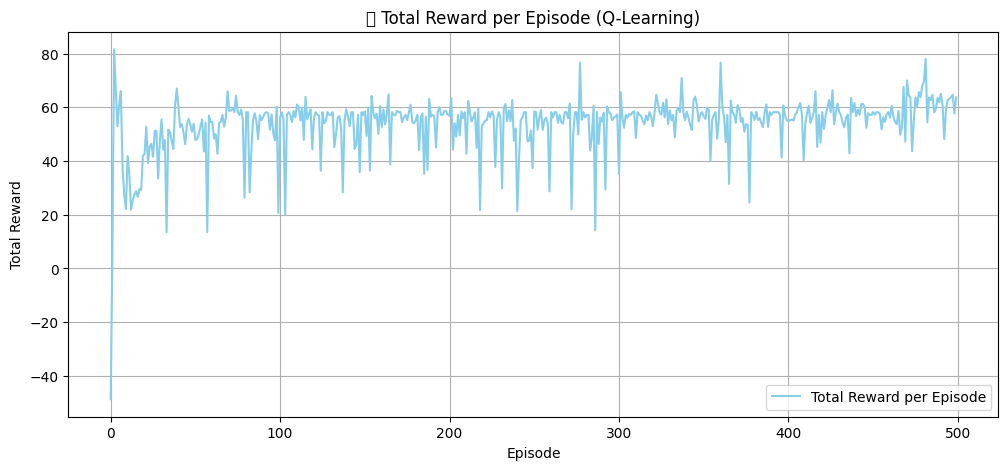

/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


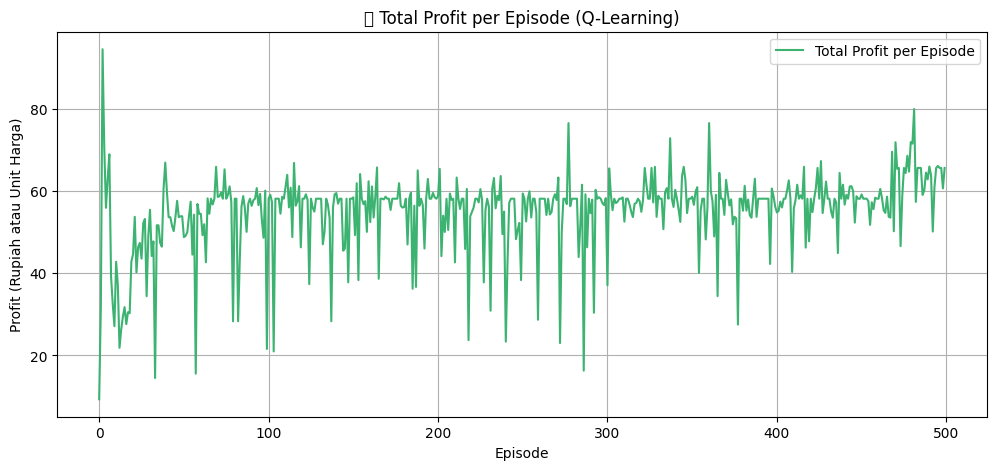

In [ ]:
# Plot total reward
plt.figure(figsize=(12, 5))
plt.plot(all_rewards, label='Total Reward per Episode', color='skyblue')
plt.title('📈 Total Reward per Episode (Q-Learning)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
plt.show()

# Plot total profit
plt.figure(figsize=(12, 5))
plt.plot(all_profits, label='Total Profit per Episode', color='mediumseagreen')
plt.title('💰 Total Profit per Episode (Q-Learning)')
plt.xlabel('Episode')
plt.ylabel('Profit (Rupiah atau Unit Harga)')
plt.grid(True)
plt.legend()
plt.show()